### Imports necesarios

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

## 1. Introducción
### En este cuaderno vamos a analizar el historico de acciones en bolsa de la empresa Take-Two Interactive Software, Inc. (TTWO), conocida en la industria de los videojuegos por juegos como la saga Grand Theft Auto, Borderlands, Red Dead, BioShock, Mafia: The City of Lost Heaven, WWE y más
### Origen de los datos: https://finance.yahoo.com/quote/TTWO/history/

## 2. Carga de datos y presentación de columnas

In [32]:
df = pd.read_csv("TTWO_historical_data.csv")
df.head()

,Date,Close,High,Low,Open,Volume
0,1997-04-15,3.916425,3.916425,3.416456,3.666441,1785600
1,1997-04-16,3.708104,4.166410,3.583112,3.916425,443700
2,1997-04-17,3.833096,4.083081,3.749768,3.749768,252150
3,1997-04-18,3.999753,3.999753,3.833096,3.833096,165900
4,1997-04-21,3.999753,3.999753,3.916425,3.916425,77400


### **Date:** Fecha de la cotización en formato AAAA-MM-DD.
### **Close:** Precio de cierre de la acción al final de la jornada bursátil.
### **High:** Precio más alto alcanzado por la acción durante el día.
### **Low:** Precio más bajo alcanzado por la acción durante el día.
### **Open:** Precio de apertura de la acción al inicio de la jornada bursátil.
### **Volume:** Número total de acciones negociadas en ese día.

In [33]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7031 entries, 0 to 7030
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    7031 non-null   object 
 1   Close   7031 non-null   float64
 2   High    7031 non-null   float64
 3   Low     7031 non-null   float64
 4   Open    7031 non-null   float64
 5   Volume  7031 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 329.7+ KB


None

In [34]:
display(df.describe())

,Close,High,Low,Open,Volume
count,7031.000000,7031.000000,7031.000000,7031.000000,7.031000e+03
mean,50.671251,51.402618,49.913069,50.671638,1.725066e+06
std,57.061557,57.749930,56.334312,57.064362,1.861216e+06
min,3.333127,3.416456,2.999815,3.249799,0.000000e+00
25%,11.430000,11.662973,11.150000,11.399648,9.049000e+05
50%,19.652121,20.080000,19.268811,19.678786,1.373550e+06
75%,102.105000,103.299999,99.905003,101.555000,2.024200e+06
max,217.949997,218.750000,212.460007,218.589996,5.279740e+07


In [35]:
df.isna().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

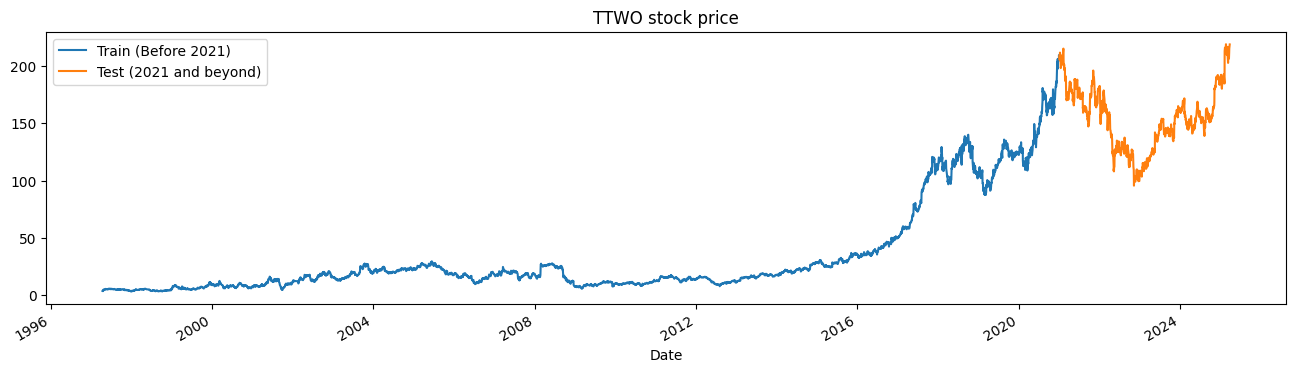

In [36]:

# Convertir 'Date' a datetime
df['Date'] = pd.to_datetime(df['Date'])

# Establecer la columna 'Date' como índice
df.set_index('Date', inplace=True)

# Función para graficar
tstart = 1997
tend = 2020

def train_test_plot(df, tstart, tend):
    df.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    df.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("TTWO stock price")
    plt.show()

# Llamar a la función
train_test_plot(df, tstart, tend)

### Calculamos el precio medio para cada dia, columna que vamos a usar en los diferentes modelos

In [37]:
df['MeanPrice'] = (df['High'] + df['Low']) / 2
display(df[['High', 'Low', 'MeanPrice']].head(10))

,High,Low,MeanPrice
Date,,,
1997-04-15,3.916425,3.416456,3.666441
1997-04-16,4.166410,3.583112,3.874761
1997-04-17,4.083081,3.749768,3.916425
1997-04-18,3.999753,3.833096,3.916425
1997-04-21,3.999753,3.916425,3.958089
1997-04-22,3.999753,3.916425,3.958089
1997-04-23,4.499722,3.916425,4.208074
1997-04-24,4.999691,4.416394,4.708043
1997-04-25,4.916363,4.416394,4.666379


### Dividimos el conjunto de pruebas y el de validación

In [38]:
def train_test_split(df, tstart, tend):
    train = df.loc[f"{tstart}":f"{tend}", "MeanPrice"].values
    test = df.loc[f"{tend+1}":, "MeanPrice"].values
    return train, test
training_set, test_set = train_test_split(df, tstart, tend)

### Estandarizamos los datos para eliminar valoires atípicos y anómalias

In [39]:
sc = MinMaxScaler(feature_range=(0, 1))
# Hacer el reshape es necesario porque MinMaxScaler
# espera una entrada en forma de columnas, donde cada fila representa una muestra y cada columna una característica.
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

### Construis X_train y y_train

In [40]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [41]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)
print(X_train.shape)

(5910, 60, 1)


In [42]:
X_train

array([[[0.00204466],
        [0.00306699],
        [0.00327146],
        ...,
        [0.01042777],
        [0.01124563],
        [0.01165457]],

       [[0.00306699],
        [0.00327146],
        [0.00327146],
        ...,
        [0.01124563],
        [0.01165457],
        [0.01124564]],

       [[0.00327146],
        [0.00327146],
        [0.00347592],
        ...,
        [0.01165457],
        [0.01124564],
        [0.01104117]],

       ...,

       [[0.77420646],
        [0.78431587],
        [0.78986132],
        ...,
        [0.97381855],
        [0.98010017],
        [0.97865243]],

       [[0.78431587],
        [0.78986132],
        [0.7766602 ],
        ...,
        [0.98010017],
        [0.97865243],
        [0.97978117]],

       [[0.78986132],
        [0.7766602 ],
        [0.77413285],
        ...,
        [0.97865243],
        [0.97978117],
        [0.99359573]]])

## Modelo LSTM

In [43]:
set_seed(455)
np.random.seed(455)

# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

c:\Users\domid\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 125)            │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

### Mismo modelo usando la API funcional

In [44]:
from tensorflow import keras
from tensorflow.keras import layers

# Definir la entrada
inputs = keras.Input(shape=(n_steps, features))

# Capa LSTM
x = layers.LSTM(units=125, activation="tanh")(inputs)

# Capa densa de salida
outputs = layers.Dense(units=1)(x)

# Crear el modelo
model_lstm = keras.Model(inputs=inputs, outputs=outputs)

# Compilar el modelo
model_lstm.compile(optimizer="RMSprop", loss="mse")

# Resumen del modelo
model_lstm.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 125)            │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento del modelo

In [45]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0054
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1304e-04
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.2726e-04
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.8872e-04
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.6322e-04
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.4512e-04
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.3218e-04
Epoch 8/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.2278e-04
Epoch 9/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.1560e-04
Epoch 10/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0988e-04
Epoch 11/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0526e-04
Epoch 12/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0104e-04
Epoch 13/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 9.6652e-05
Epoch 14/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 9.

In [46]:
dataset_total = df.loc[:,"MeanPrice"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [47]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("TTWO Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("TTWO Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

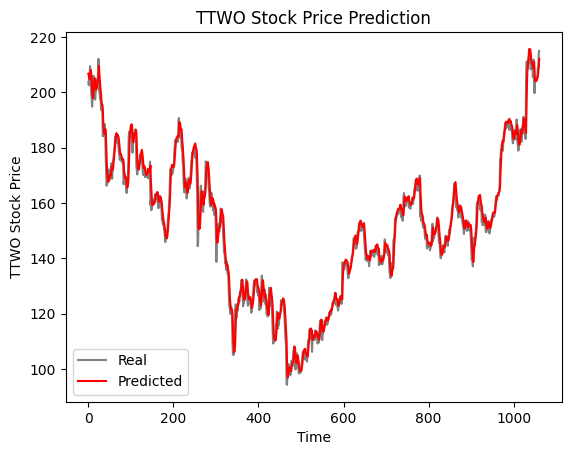

In [48]:
plot_predictions(test_set,predicted_stock_price)

In [49]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 3.61.


## Modelo GRU

## Modelo GRU 2

## Modelo GRU 3